In [6]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from DataLoad import load_to_dataframe, filter_instruments
from feature_generator import create_features, para_dict
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [16]:
# Read in Features, Labels and Parameter

Model_Name = 'FFT_Complex_1'

param_file = Model_Name + '_Param.txt'
feature_file = Model_Name + '_features.npy'
label_file = Model_Name + '_labels.npy'
modelstore = Path.cwd() / 'models'



with open(modelstore / param_file, 'r') as file:
    Feature_Params = json.load(file)
    
Feature_Params   
 
    
    
features = np.load(modelstore / feature_file)
label = np.load(modelstore / label_file)

for keys, values in Feature_Params.items():
    print(keys, ': ', values)

print()
print('Labels: ', label.shape)
print('Features: ', features.shape)
    

Description :  Only FFT transformation with 2 channels for real and imaginary part, linear absolute values between 0 and 1
Data :  /home/mirko/Downloads/IRMAS_Raw.pkl
Transformation :  FFT_Complex_1
sampling_rate :  44100
hop_length :  2048
fft_window :  1024
no_mel_bin :  27
loudness_normalization :  linear
fmin :  0.0
fmax :  11025.0
length_s :  3
Input_Dim :  [513, 65]

Labels:  (6705,)
Features:  (6705, 513, 65)


In [17]:
# Train test split

feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size=0.3)

In [18]:
print(feature_train.shape)
print(feature_test.shape)
print(label_train.shape)
print(label_test.shape)

(4693, 513, 65)
(2012, 513, 65)
(4693,)
(2012,)


In [10]:
#Define the model

model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(13, 65, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(11))
model.add(layers.Activation('softmax'))


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 64, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 32, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 31, 64)         8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 15, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 14, 64)         16448     
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
history = model.fit(feature_train, label_train, epochs=50, 
                    validation_data=(feature_test, label_test))

Train on 4693 samples, validate on 2012 samples
Epoch 1/50
4693/4693 [==============================] - 1s 234us/sample - loss: 2.3799 - accuracy: 0.1225 - val_loss: 2.3614 - val_accuracy: 0.1710
Epoch 2/50
4693/4693 [==============================] - 1s 170us/sample - loss: 2.3523 - accuracy: 0.1658 - val_loss: 2.3416 - val_accuracy: 0.1849
Epoch 3/50
4693/4693 [==============================] - 1s 169us/sample - loss: 2.3469 - accuracy: 0.1762 - val_loss: 2.3412 - val_accuracy: 0.1899
Epoch 4/50
4693/4693 [==============================] - 1s 163us/sample - loss: 2.3384 - accuracy: 0.1869 - val_loss: 2.3570 - val_accuracy: 0.1675
Epoch 5/50
4693/4693 [==============================] - 1s 163us/sample - loss: 2.3326 - accuracy: 0.1922 - val_loss: 2.3224 - val_accuracy: 0.2073
Epoch 6/50
4693/4693 [==============================] - 1s 164us/sample - loss: 2.3312 - accuracy: 0.1896 - val_loss: 2.3298 - val_accuracy: 0.2008
Epoch 7/50
4693/4693 [==============================] - 1s 167us

In [15]:
history_file = Model_Name + '_history.pkl'

with open(modelstore / history_file, 'wb') as f:
    pickle.dump(history.history, f)    

2012/2012 - 0s - loss: 2.2186 - accuracy: 0.3186


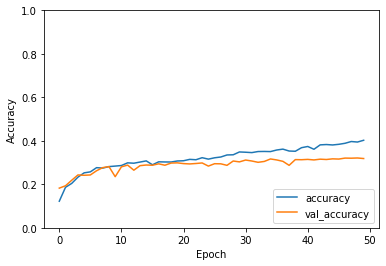

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(feature_test,  label_test, verbose=2)


In [78]:
type(feature_train[1][1][1][0])

numpy.float32

In [84]:
label_train = np.array(label_train)
label_test = np.array(label_test)

In [82]:
type(label_train)

numpy.ndarray

In [127]:
example = feature_train[5]

example = np.expand_dims(example, axis=0)
example.shape

(1, 13, 65, 1)

In [160]:
x = 230

example = feature_test[x]
label = label_test[x]
example = np.expand_dims(example, axis=0)
result = model(example)

In [161]:
print(label)
print(np.argmax(result))
print(np.max(result),'%')

9
9
0.9472844 %


In [2]:
para_dict()